<a href="https://colab.research.google.com/github/EmanuelAlogna/MRI-generation/blob/master/src/MRI_generation_with_pix2pix(P2P_t2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import time
import math

print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def get_feature_description(modalities):                                                   
                                                                                           
    feature_description =lambda mod : {                                                    
                            mod+'_mri': tf.io.FixedLenFeature([], tf.string),              
                            mod+'_path': tf.io.FixedLenFeature([], tf.string),             
                                                                                           
                            mod+'_mri_min': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_min_src': tf.io.FixedLenFeature([], tf.float32),     
                            mod+'_mri_max': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_max_src': tf.io.FixedLenFeature([], tf.float32),     
                                                                                           
                            mod+'_mri_lperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_mri_lperc_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_x_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_y_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_x_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_y_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                                                                                           
                            mod+'_x_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_y_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_z_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                                                                                           
                            mod+'_z_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_x_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_y_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_patient': tf.io.FixedLenFeature([], tf.string),          
                            mod+'_sample_number': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_grade': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_location': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_version': tf.io.FixedLenFeature([], tf.string),  
                            mod+'_dataset_name': tf.io.FixedLenFeature([], tf.string),     
                            mod+'_mri_type': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_split': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_mri_seq': tf.io.FixedLenFeature([], tf.string),  
                          }                                                                
    features = {}                                                                          
    for mod in modalities:
        features.update(feature_description(mod))
    return features

In [0]:
#BUFFER_SIZE = 400
BATCH_SIZE = 32

In [0]:
use_gzip_compression = True

def load_dataset(name, mri_type, center_crop=None, random_crop=None, filter=None, batch_size=BATCH_SIZE, cache=True, 
                 prefetch_buffer=1, shuffle_buffer=128, interleave=1, cast_to=tf.float32, clip_labels_to=0.0, 
                 take_only=None, shuffle=True, infinite=False, n_threads=os.cpu_count()):
    def parse_sample(sample_proto):
        parsed = tf.io.parse_single_example(sample_proto, get_feature_description(["OT"]+mri_type))
        # Decoding image arrays
        
        slice_shape = [parsed['OT_x_dimension'.format(mri_type[0])], parsed['OT_y_dimension'], 1]
        # Decoding the ground truth
        parsed['seg'] = tf.cast(tf.reshape(tf.io.decode_raw(parsed['OT_mri'], tf.float32), shape=slice_shape), dtype=cast_to)
        # Decode each channel and stack in a 3d volume
        stacked_mri = list()
        for mod in mri_type:
            stacked_mri.append(tf.cast(tf.reshape(tf.io.decode_raw(parsed['{}_mri'.format(mod)], tf.float32), shape=slice_shape), dtype=cast_to))
        parsed['mri'] = tf.concat(stacked_mri, axis=-1)
        # Clipping the labels if requested
        parsed['seg'] = tf.clip_by_value(parsed['seg'], 0.0, clip_labels_to) if clip_labels_to else parsed['seg']
        
        # Cropping
        if random_crop or center_crop:
            # Stacking the mri and the label to align the crop shape
            mri_seg = tf.concat([parsed['mri'], parsed['seg']], axis=-1)
            if random_crop:
                random_crop[-1] = mri_seg.shape[-1] 
                cropped = tf.image.random_crop(mri_seg, size=random_crop)
            else:
                cropped = tf.image.resize_with_crop_or_pad(mri_seg,center_crop[0],center_crop[1])
            # Splitting back
            parsed['mri'] = cropped[:,:,:len(mri_type)]
            parsed['seg'] = cropped[:,:,len(mri_type):]
        
        return parsed
    
    path = './drive/My Drive/MRI-generation/{}.tfrecords'.format(name)
    dataset = tf.data.TFRecordDataset(path, compression_type='GZIP' if use_gzip_compression else "")
    dataset = dataset.filter(filter) if filter is not None else dataset
    dataset = dataset.take(take_only) if take_only is not None else dataset

    # You should generally cache after loading and preprocessing the data, 
    # but before shuffling, repeating, batching and prefetching”
    dataset = dataset.cache() if cache else dataset
    if shuffle and infinite:
        dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(shuffle_buffer))
    else:
        dataset = dataset.shuffle(shuffle_buffer, reshuffle_each_iteration=True) if shuffle else dataset
        dataset = dataset.repeat() if infinite else dataset
    dataset = dataset.map(parse_sample, num_parallel_calls=None)
    dataset = dataset.batch(batch_size) if batch_size > 0 else dataset
    

    if interleave > 1:
        dataset = dataset.interleave(lambda x: tf.data.Dataset.from_tensors(x).repeat(interleave), cycle_length=n_threads, block_length=interleave, num_parallel_calls=n_threads)
  
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
# loading all the dataset, with only modality T1 and T2
# I'll focus now on synthesizing T2 from T1

def load_datasets():
    validation = load_dataset('brats2015_validation_crop_mri', ['MR_T1', 'MR_T2'])
    training = load_dataset('brats2015_training_crop_mri', ['MR_T1', 'MR_T2'])
    testing = load_dataset('brats2015_testing_crop_mri', ['MR_T1', 'MR_T2'])
    return training, validation , testing

In [0]:
training, validation, testing = load_datasets() # I'll use this in case I get stuck with the cache.

In [0]:
# PROCESSING IMAGES IN THE BATCH
@tf.function
def process_batch(batch):   # takes in input a raw_record[mod].numpy()
    batch = tf.io.decode_raw(batch, tf.float32)
    batch = tf.reshape(batch, (BATCH_SIZE, 180, 180))
    paddings = tf.constant([[0, 0], [38, 38], [38, 38]])
    batch = tf.pad(batch, paddings, "CONSTANT")
    batch = tf.expand_dims(batch, axis=3)
    return batch
    
# final shape will be (bs, 256, 256, 1): now the batch is ready to be fed to the GAN

In [0]:
# this function preprocesses the input image and the ground truth from a raw_record
# images in the return are then ready to be fed into the GAN
@tf.function
def take_images_from_raw(raw_record):
    n = 0 
    for idx, mod in enumerate(modalities):
        image = raw_record[mod]
        if idx == 0:
            inp = process_batch(image) 
        else:
            ground_truth = process_batch(image)
    return inp, ground_truth

(32, 256, 256, 1) (32, 256, 256, 1)
Batch with a size of 32 and dimension of (256,256) per image


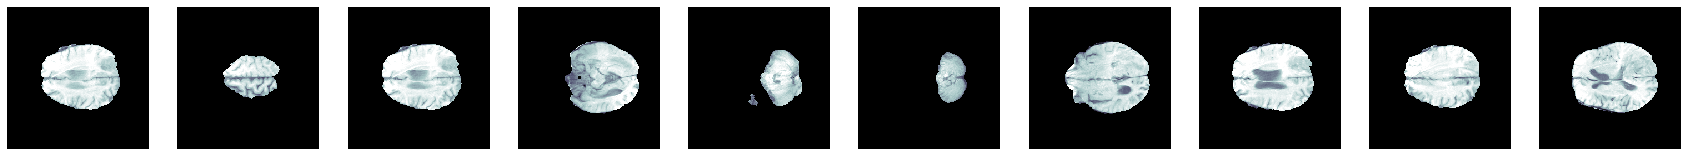

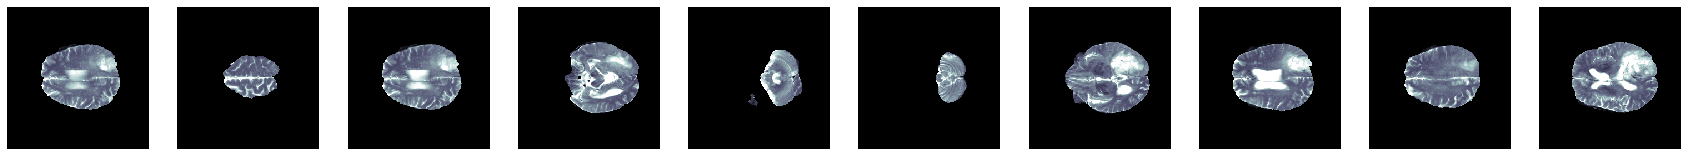

In [10]:
modalities = ['MR_T1_mri', 'MR_T2_mri']

for raw_record in validation.take(1):
    inp, ground_truth = take_images_from_raw(raw_record)

    print(inp.shape, ground_truth.shape)

    plt.figure(1 , figsize = (30, 20))
    print("Batch with a size of {} and dimension of (256,256) per image".format(BATCH_SIZE))
    n = 0 
    for i in range(10):     # batch size is different from 10, but let's show just 10 images 
    # to see all the images belonging to the batch, just change 10 with 'BATCH_SIZE'
        n += 1
        plt.subplot(2 , 10 , n)
        img = inp[i]
        plt.imshow(tf.squeeze(img), cmap='bone')
        plt.axis('off')

    n = 0 
    plt.figure(2 , figsize = (30, 20))
    for i in range(10):    
        n += 1
        plt.subplot(2 , 10 , n)
        img = ground_truth[i]
        plt.imshow(tf.squeeze(img), cmap='bone')
        plt.axis('off')

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 1

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [0]:
# hint from the web: Unfortunately, UNet does not work with arbitrary input sizes. Try ResNet instead.

def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,1], batch_size=BATCH_SIZE)

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]
  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                                         kernel_initializer=initializer,activation='tanh') # (bs, 256, 256, 1)
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
generator = Generator()
#generator.summary()

In [0]:
def rescale(x, xmin, xmax, a, b):
    return (a + (b-a)*(x-xmin)/(xmax-xmin))  
    # to rescale in the range [0, 1], 'a' must be 0 and 'b' = 1

In [0]:
def normalize(image):
    image_normalized = image.numpy()
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = np.amax(image[i])
        min_value = np.amin(image[i])
        image_normalized[i] = rescale(image[i], min_value, max_value, 0, 1)
    return image_normalized

In [0]:
def normalize2(image):
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(prediction[i])
        min_value = tf.math.reduce_min(prediction[i])
        x = rescale(prediction[i], min_value, max_value, 0, 1)
        image_normalized = image_normalized.write(i, x)
    image_normalized = image_normalized.stack()
    return image_normalized

**Defining all the quantitative metrics (PSNR, SSIM, MSE and MS-SSIM(?))**

In [0]:
def compute_psnr(image1, image2):
    # Compute PSNR over tf.float32 Tensors.
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    psnr = tf.image.psnr(im1, im2, max_val=1.0)
    mean = tf.reduce_mean(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    std = tf.math.reduce_std(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    # In the computation of mean and std, I'm ignoring the nan values
    # Why 'nan' values? nan happens when there is an image with max_value and min_value = 0.0 so a black image
    # the PSNR would be inf (image is totally similar to the ground truth)
    # be rescaling the image, the max_value and min_value would become nan and so the PSNR
    return mean, std

In [0]:
# I want to compute, first thing, the MSE between ground truth and generated one. The tf.function gives me a Tensor 32x256x256:
# MSE is computed PIXEL per PIXEL, so per each of the 32 matrix 256x256, I average (1) the values of the 256x256 pixels obtaining
# an array of 32 elements, containing the MSEs of each image belonging to the batch. Then I can average (2) these 32 to have 
# I should not average the whole 32x256x256 in one step. The result would have same mean but slightly different std.
# I want first to obtain the MSE of each image... then I average across the batch only to have smth more accurate.

def compute_mse(image1, image2):       # mean squared error
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    mse = tf.metrics.mean_squared_error(im1,im2)
    # In this way is possible to do Variable item-assignment with tensors 
    mse_per_image = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        x = tf.reduce_mean(tf.boolean_mask((mse[i]), tf.math.is_finite(mse[i]))) 
        mse_per_image = mse_per_image.write(i, x)
    mse_per_image = mse_per_image.stack()
    mean = tf.reduce_mean(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    std = tf.math.reduce_std(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    return mean, std

In [0]:
from sklearn.metrics import mean_squared_error
# MSE1 has a shape of (32, 256, 256) values and then they are all averaged. MSE2 has a shape of (32).
# The first one is the MSE comparing PIXEL per PIXEL, the MSE2 is computed comparing IMAGE per IMAGE
#The results are (for example):
# MSE1: 0.3000459372997284 ± 0.09557260572910309
# MSE2: 0.30004595816135404 ± 0.023979207728746815

# Let's use the second one, since it seems to be more precise (I'm removing high MSE due to black images)

def compute_mse2(image1, image2):       # mean squared error
    mse = np.empty(BATCH_SIZE)
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    for i in range (BATCH_SIZE):
        max_value_image2 = np.amax(image2[i])
        min_value_image2 = np.amin(image2[i])
        if np.isnan(min_value_image2) or np.isnan(max_value_image2):
            mse[i] = float('nan') 
            # I don't want to compute MSE of 'nan' values, so of images totally black. So I put 'nan' also in the
            # array of MSE values: in this way it won't be included in the mean ± std
        else:
            mse[i] = (mean_squared_error(image1[i], image2[i]))
        #print(i, min_value_image2, max_value_image2)
    mean = tf.reduce_mean(tf.boolean_mask((mse), tf.math.is_finite(mse)))
    std = tf.math.reduce_std(tf.boolean_mask((mse), tf.math.is_finite(mse)))

    return mean, std

In [0]:
def compute_ssim(image1, image2):
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    ssim = tf.image.ssim(im1, im2, max_val=1)
    mean = tf.reduce_mean(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    std = tf.math.reduce_std(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    return mean, std

In [23]:
pip install -U scikit-image

     |████████████████████████████████| 26.5MB 359kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.15.0
    Uninstalling scikit-image-0.15.0:
      Successfully uninstalled scikit-image-0.15.0


In [24]:
import skimage
print(skimage.__version__)

0.16.2


In [0]:
from skimage.metrics import structural_similarity
def compute_ssim2(image1, image2):
    mse2 = np.empty(BATCH_SIZE)
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    for i in range (BATCH_SIZE):  # guassian_weights and sampel_covariance must be used in order to match the definition
        # of the original paper of the metric SSIM
        mse2[i] = (structural_similarity(image1[i], image2[i], gaussian_weights=True, data_range=1.0, use_sample_covariance=False))
        
        #print(i, min_value_image2, max_value_image2)
    print()
    print("Values of SSIM obtained using sklearn metric")
    #print(mse2)    
    mean = tf.reduce_mean(tf.boolean_mask((mse2), tf.math.is_finite(mse2)))
    std = tf.math.reduce_std(tf.boolean_mask((mse2), tf.math.is_finite(mse2)))
    mean = (f'{mean:.4f}')
    std = (f'{std:.4f}')
    print("SSIM3: {} ± {}".format(mean, std))

In [26]:
"""
for raw_record in validation.take(10):
    inp, ground_truth = take_images_from_raw(raw_record)
    prediction = generator(inp, training=False)

    prediction_normalized = normalize(prediction)



    # MSE, PSNR, SSIM
    mean, std = compute_mse(ground_truth, prediction_normalized)
    print("MSE: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_mse2(ground_truth, prediction_normalized)
    print("MSE2: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_psnr(ground_truth, prediction_normalized)
    print("PSNR: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_ssim(ground_truth, prediction_normalized)
    print("SSIM: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    compute_ssim(ground_truth, prediction_normalized)

    prediction_normalized2 = normalize2(prediction)



    # MSE, PSNR, SSIM
    mean, std = compute_mse(ground_truth, prediction_normalized2)
    print("MSE: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_mse2(ground_truth, prediction_normalized2)
    print("MSE2: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_psnr(ground_truth, prediction_normalized2)
    print("PSNR: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_ssim(ground_truth, prediction_normalized2)
    print("SSIM: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    compute_ssim2(ground_truth, prediction_normalized2)
    print()
"""

'\nfor raw_record in validation.take(10):\n    inp, ground_truth = take_images_from_raw(raw_record)\n    prediction = generator(inp, training=False)\n\n    prediction_normalized = normalize(prediction)\n\n\n\n    # MSE, PSNR, SSIM\n    mean, std = compute_mse(ground_truth, prediction_normalized)\n    print("MSE: {} ± {}".format((f\'{mean:.4f}\'), (f\'{std:.4f}\')))\n    mean, std = compute_mse2(ground_truth, prediction_normalized)\n    print("MSE2: {} ± {}".format((f\'{mean:.4f}\'), (f\'{std:.4f}\')))\n    mean, std = compute_psnr(ground_truth, prediction_normalized)\n    print("PSNR: {} ± {}".format((f\'{mean:.4f}\'), (f\'{std:.4f}\')))\n    mean, std = compute_ssim(ground_truth, prediction_normalized)\n    print("SSIM: {} ± {}".format((f\'{mean:.4f}\'), (f\'{std:.4f}\')))\n    compute_ssim(ground_truth, prediction_normalized)\n\n    prediction_normalized2 = normalize2(prediction)\n\n\n\n    # MSE, PSNR, SSIM\n    mean, std = compute_mse(ground_truth, prediction_normalized2)\n    prin

In [0]:
#@tf.function
def generate_images(model, test_input, tar, train):
    
    # FROM STACKOVERFLOW:
    # Some neural network layers behave differently during training and inference, for example Dropout and BatchNorm
    # During training, dropout will randomly drop out units and correspondingly scale up activations of the remaining units.
    # During inference (training=false) it does nothing (since you usually don't want the randomness of dropping out units here).
    # The training argument lets the layer know which of the two "paths" it should take. 
    # If you set this incorrectly, your network might not behave as expected.
    
    prediction = model(test_input, training=train)
    
    print("1st sample from the batch. Dimension of (256,256) per image".format(BATCH_SIZE))
    
    display_list = [test_input, tar, prediction]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    plt.figure(1 , figsize = (12 , 12))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(tf.squeeze(display_list[i][0]), cmap='bone') # [0] = I'm showing only the 1st sample
        plt.axis('off')
    plt.show()
    return prediction


In [28]:
"""
def generate_complete_batch(model, test_input, tar, train):
    prediction = model(test_input, training=train)

    print(prediction.shape)
    print("Batch with a size of {} and dimension of (256,256) per image".format(BATCH_SIZE))
    display_list = [test_input, tar, prediction]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.figure(i+1 , figsize = (30 , 30))
        n = 0
        for j in range(BATCH_SIZE):  # batch size is different from 10, but let's show just 10 images.
            n += 1
            plt.subplot(1, BATCH_SIZE, n).title.set_text(title[i])
            plt.imshow(np.squeeze(display_list[i][j]), cmap='bone')
            plt.axis('off')
"""

'\ndef generate_complete_batch(model, test_input, tar, train):\n    prediction = model(test_input, training=train)\n\n    print(prediction.shape)\n    print("Batch with a size of {} and dimension of (256,256) per image".format(BATCH_SIZE))\n    display_list = [test_input, tar, prediction]\n    title = [\'Input Image\', \'Ground Truth\', \'Predicted Image\']\n\n    for i in range(3):\n        plt.figure(i+1 , figsize = (30 , 30))\n        n = 0\n        for j in range(BATCH_SIZE):  # batch size is different from 10, but let\'s show just 10 images.\n            n += 1\n            plt.subplot(1, BATCH_SIZE, n).title.set_text(title[i])\n            plt.imshow(np.squeeze(display_list[i][j]), cmap=\'bone\')\n            plt.axis(\'off\')\n'


**Prediction of T2, given random input T1 and ground truth T2**


1st sample from the batch. Dimension of (256,256) per image


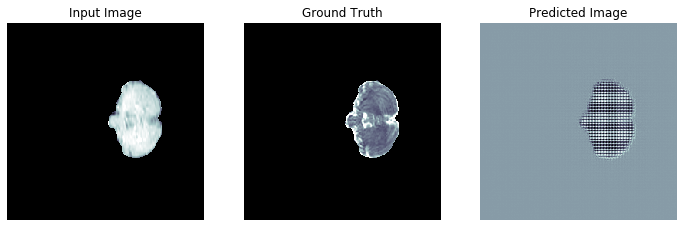

MSE: 0.3320 ± 0.0257
MSE2: 0.3320 ± 0.0257
PSNR: 4.8011 ± 0.3275
SSIM: 0.0003 ± 0.0005
MSE: 0.3320 ± 0.0257
MSE2: 0.3320 ± 0.0257
PSNR: 4.8011 ± 0.3275
SSIM: 0.0003 ± 0.0005



In [29]:
modalities = ['MR_T1_mri', 'MR_T2_mri']
for raw_record in testing.take(1):
    inp, ground_truth = take_images_from_raw(raw_record)
# Shape of both input and target is: (bs, 256, 256, 1)

# GENERATE A NEW MODALITY:
# the functions below do exactly the same thing, but the first prints only the first sample from the batch, 
# while w/the second ALL the images of the batch are printed out.

    prediction = generate_images(generator, inp, ground_truth, False)
    #generate_complete_batch(generator, example_input, example_target, False)

    prediction_normalized = normalize(prediction)



    # MSE, PSNR, SSIM
    mean, std = compute_mse(ground_truth, prediction_normalized)
    print("MSE: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_mse2(ground_truth, prediction_normalized)
    print("MSE2: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_psnr(ground_truth, prediction_normalized)
    print("PSNR: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_ssim(ground_truth, prediction_normalized)
    print("SSIM: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))


    prediction_normalized2 = normalize2(prediction)



    # MSE, PSNR, SSIM
    mean, std = compute_mse(ground_truth, prediction_normalized2)
    print("MSE: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_mse2(ground_truth, prediction_normalized2)
    print("MSE2: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_psnr(ground_truth, prediction_normalized2)
    print("PSNR: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std = compute_ssim(ground_truth, prediction_normalized2)
    print("SSIM: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    print()

In [0]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)



  return total_gen_loss, gan_loss, l1_loss

In [0]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image', batch_size=BATCH_SIZE)
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image', batch_size=BATCH_SIZE)

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) #(bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [0]:
discriminator = Discriminator()
#discriminator.summary()

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [36]:
"""
def take_images_from_raw_enum(raw_record, modalities):
    # so each raw_record is a tuple. each tuple contains all the features.
    # each features is stored inside the tuple as a tensor. how to access to it?
    
    # to retrieve an image:
    inp_from_enum = np.reshape(np.frombuffer(raw_record[1][modalities[0]].numpy()[0], dtype=np.float32), (180, 180))
    ground_truth_from_enum = np.reshape(np.frombuffer(raw_record[1][modalities[1]].numpy()[0], dtype=np.float32), (180, 180))
    inp_from_enum = np.expand_dims(inp_from_enum, axis=2)
    ground_truth_from_enum = np.expand_dims(ground_truth_from_enum, axis=2)
    # the shape now is (180,180,1)  
    # I need to resize the input images in order to feed them to the U-net. 
    # With 128 I would decrease the resolution, so let's increase it to 256
    inp_from_enum_resized, ground_truth_from_enum_resized = resize(inp_from_enum, ground_truth_from_enum, 256, 256)
    # the shape now is (256,256,1)

    # NOW IS READY FOR THE generate_images METHOD
    # to retrieve the patient_code, do this:  (not useful right now)
    #test2 = raw_record[1]['MR_T1_patient'].numpy()[0]
    #patient = test2.decode("utf-8")
    inp_from_enum_resized = inp_from_enum_resized[tf.newaxis,...]
    ground_truth_from_enum_resized = ground_truth_from_enum_resized[tf.newaxis,...]

    return inp_from_enum_resized, ground_truth_from_enum_resized
"""

'\ndef take_images_from_raw_enum(raw_record, modalities):\n    # so each raw_record is a tuple. each tuple contains all the features.\n    # each features is stored inside the tuple as a tensor. how to access to it?\n    \n    # to retrieve an image:\n    inp_from_enum = np.reshape(np.frombuffer(raw_record[1][modalities[0]].numpy()[0], dtype=np.float32), (180, 180))\n    ground_truth_from_enum = np.reshape(np.frombuffer(raw_record[1][modalities[1]].numpy()[0], dtype=np.float32), (180, 180))\n    inp_from_enum = np.expand_dims(inp_from_enum, axis=2)\n    ground_truth_from_enum = np.expand_dims(ground_truth_from_enum, axis=2)\n    # the shape now is (180,180,1)  \n    # I need to resize the input images in order to feed them to the U-net. \n    # With 128 I would decrease the resolution, so let\'s increase it to 256\n    inp_from_enum_resized, ground_truth_from_enum_resized = resize(inp_from_enum, ground_truth_from_enum, 256, 256)\n    # the shape now is (256,256,1)\n\n    # NOW IS READY

In [37]:
"""
for raw_record_enum in training.take(1):
        input_image, target = take_images_from_raw(raw_record_enum)

        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)

        
        a = gen_total_loss
        print(a.numpy())
        print(type(gen_l1_loss)) # <class 'tensorflow.python.framework.ops.Tensor'>


#inp_from_enum = np.reshape(np.frombuffer(raw_record[1][modalities[0]].numpy()[0], dtype=np.float32), (180, 180))
"""

"\nfor raw_record_enum in training.take(1):\n        input_image, target = take_images_from_raw(raw_record_enum)\n\n        gen_output = generator(input_image, training=True)\n        disc_real_output = discriminator([input_image, target], training=True)\n        disc_generated_output = discriminator([input_image, gen_output], training=True)\n\n        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)\n\n        \n        a = gen_total_loss\n        print(a.numpy())\n        print(type(gen_l1_loss)) # <class 'tensorflow.python.framework.ops.Tensor'>\n\n\n#inp_from_enum = np.reshape(np.frombuffer(raw_record[1][modalities[0]].numpy()[0], dtype=np.float32), (180, 180))\n"

**TRAINING PHASE**

In [0]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # G produces fake images of T2
        gen_output = generator(input_image, training=True)

        # showing to D a batch of real images of T2
        disc_real_output = discriminator([input_image, target], training=True)
        
        # showing to D a batch fake images of T2
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)


    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    #return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

In [0]:
def fit(train_ds, epochs, test_ds):

    for epoch in range(epochs):
        start = time.time()
    
        # this has nothing to do with the training. 
        # It's just to show qualitatively the progress of the GAN in generating a new image.
        for raw_record in test_ds.take(1):
            example_input, example_target = take_images_from_raw(raw_record)
            gen_output = generate_images(generator, example_input, example_target, True)

            gen_output_normalized = normalize2(gen_output)
            # MSE, PSNR, SSIM
            mean, std = compute_mse(example_target, gen_output_normalized)
            print("MSE: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
            mean2, std2 = compute_psnr(example_target, gen_output_normalized)
            print("PSNR: {} ± {}".format((f'{mean2:.4f}'), (f'{std2:.4f}')))
            mean3, std3 = compute_ssim(example_target, gen_output_normalized)
            print("SSIM: {} ± {}".format((f'{mean3:.4f}'), (f'{std3:.4f}')))

            
        print()
        print("Epoch: ", epoch+1)
        # Train
        n = 0

        # 875 samples with batch = 32
        for raw_record_enum in train_ds.take(875):
            n += 1
            input_image, target = take_images_from_raw(raw_record_enum)
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()
        """
            gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(input_image, target, epoch)
        gen_total_loss = gen_total_loss.numpy()
        gen_gan_loss = gen_gan_loss.numpy()
        gen_l1_loss = gen_l1_loss.numpy()
        disc_loss = disc_loss.numpy()
        print()
        print("Losses: ")
        print("L1 loss: {}".format(gen_l1_loss))
        print("Gen loss: {}".format(gen_gan_loss))
        print("GAN loss: {}".format(gen_total_loss))
        print("DISC loss: {}".format(disc_loss))
        print()
        """
                
            #else:
            #    train_step(input_image, target, epoch)
            # THIS IS THE ACTUAL TRAINING STEP
        

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print()
        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                            time.time()-start))

1st sample from the batch. Dimension of (256,256) per image


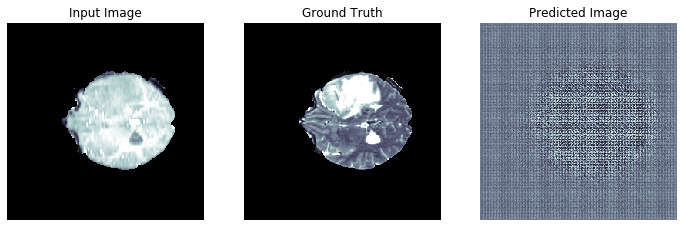

MSE: 0.3311 ± 0.0212
PSNR: 4.8089 ± 0.2719
SSIM: 0.0074 ± 0.0118

Epoch:  1
...................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................................................................

Time taken for epoch 1 is 384.124425411

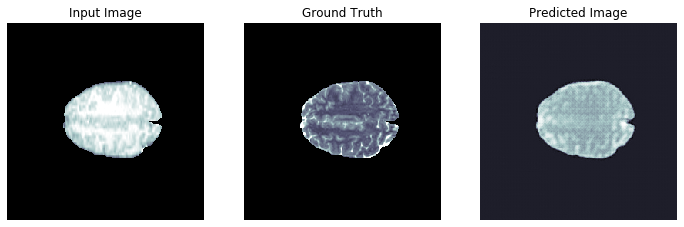

MSE: 0.3304 ± 0.0193
PSNR: 4.8164 ± 0.2532
SSIM: 0.0080 ± 0.0118

Epoch:  2
...................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................................................................

Time taken for epoch 2 is 379.459116220

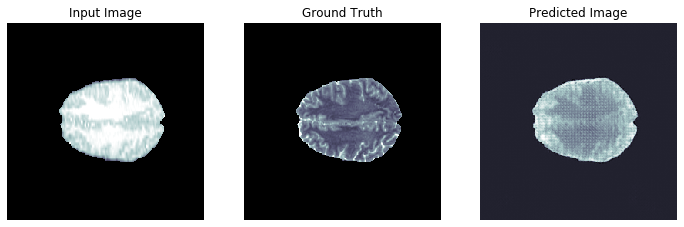

MSE: 0.3278 ± 0.0227
PSNR: 4.8544 ± 0.3019
SSIM: 0.0081 ± 0.0112

Epoch:  3
...................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................................................................

Time taken for epoch 3 is 379.336059570

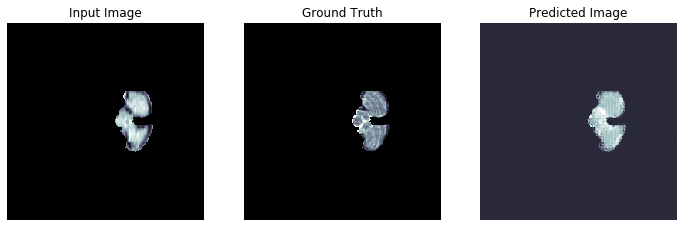

MSE: 0.3287 ± 0.0163
PSNR: 4.8370 ± 0.2164
SSIM: 0.0064 ± 0.0090

Epoch:  4
...................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................................................................

Time taken for epoch 4 is 379.229122400

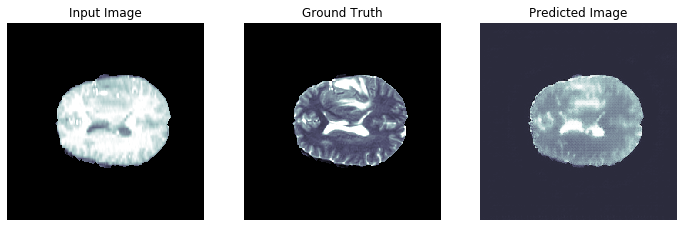

MSE: 0.3315 ± 0.0242
PSNR: 4.8072 ± 0.3166
SSIM: 0.0078 ± 0.0113

Epoch:  5
...................................................................................................
.....................................................

KeyboardInterrupt: ignored

In [40]:
EPOCHS = 10

# training, validation, testing = load_datasets() # I'll use this in case I get stuck with the cache.
# Initialize the models, so that I don't have to restart the runtime again.

fit(training, EPOCHS, testing)

In [0]:
# in the testing there are 28 patients so 128*28 = 3584 samples
# each samples has then all the scans defined in the load_dataset (up to 4 scans + the segmented area)
# if batch size is set to 32, then there are less then 100 samples.

# training: with GPU it crashes, with TPU works. a bit more of 28000 samples -> 219 patients * 128 levels.

# training with 100 samples, batch size = 1 and TPU took 46 seconds
# training with 100 samples, batch size = 1 and GPU took 7/8 seconds

# training with 1000 samples, batch size = 1, resizing to 256, GPU took 54 seconds
# training with 1000 samples, batch size = 1, padding to 256, GPU took 52 seconds

# TRAINING TIMES WITH DIFFERENT BATCH SIZES:
# training with 16 samples and batch size = 64 (so 1024 samples fed to the GAN), TPU took 209 seconds

# training with 1000 samples and batch size = 1 (so 1000 samples fed to the GAN), GPU took about 490 seconds (8 min)
# training with 250 samples and bs = 4 (so 1000 samples fed to the GAN), GPU took 127 seconds!
# training with 128 samples and bs = 8 (so 1024 samples fed to the GAN), GPU took 75 seconds!
# training with 64 samples and bs = 16 (so 1024 samples fed to the GAN), GPU took 41 seconds!
# training with 31 samples and bs = 32 (so still 992 samples fed to the GAN), GPU took 28/32/33
# training with 16 samples and bs = 64 (so 1024 samples fed to the GAN), GPU took 23/25/26 seconds!

# training with 8 samples and bs = 128, GPU took 24/25( 21 in the most recent) sec! -> not so good quality
# (It has been observed in practice that when using a larger batch there is a significant degradation in the 
# quality of the model, as measured by its ability to generalize.)
# https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network

# The resulting model may not generalize as well as a model trained with a small batch size

# tradeoff between 32 and 64. 32 seems to be qualitatively more accurate but it's a bit slower. 
# before choosing, it would be better to implement also the quantitative metrics.

# from pix2pix paper: use batch sizes between 1 and 10 depending on the experiment


# In general, batch size of 32 is a good starting point, and you should also try with 64, 128, and 256. 
# Other values (lower or higher) may be fine for some data sets, but the given range is generally the best to 
# start experimenting with. Though, under 32, it might get too slow because of significantly lower computational speed, 
# because of not exploiting vectorization to the full extent.  
# If you get an "out of memory" error, you should try reducing the mini-batch size anyway.


# training with 4 samples and bs = 256, GPU run out of memory. Resource exhausted.

In [0]:
# np.FUNCTION VS tf.FUNCTION

# np =  training with 31 samples and bs = 32 (992 samples fed to the GAN), GPU took 28/32/33
# training with 32 samples and bs = 32 (1024 samples fed to the GAN), GPU took 14/15/16/17 seconds 

In [0]:
tf.keras.backend.clear_session()  # For easy reset of notebook state.